In [1]:
import numpy as np 
import pandas as pd 

In [2]:
!pip install vit_keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=a9ec5f73779817bd7d11705cb3cf2cd26f16a7222eeaf0b9917aba6c9e6b97d8
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.3 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from vit_keras import vit, utils
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import gc

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

**Load Cifar10 data**

In [6]:
(train_data, train_label), (test_data, test_label) = cifar10.load_data()
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
train_data = (train_data/255.).astype("float32")
test_data = (test_data/255.).astype("float32")

170498071/170498071 [==============================] - 2s 0us/step


In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, random_state=seed, shuffle=True)

**Makes data augmentation generator**

In [8]:
batch_size = 32
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [9]:
checkpoint_vit = ModelCheckpoint('/content/drive/MyDrive/Research/weights/vit.h5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
)  

**Defines ViT model**

In [10]:
input_shape = (32, 32, 3) #Cifar10 image size
image_size = 224 #size after resizing image
num_classes = 10

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (image_size, image_size)))(inputs) #Resize image to  size 224x224
    base_model = vit.vit_b16(image_size=image_size, activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)
    
    base_model.trainable = False #Set false for transfer learning
    x = base_model(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation=tf.keras.activations.gelu)(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model_final = Model(inputs=inputs, outputs=outputs)
    return model_final

**Step1: Train only top layer (Transfer learning step)**

In [11]:
model = build_model()
model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
# model.fit(train_generator,
#           steps_per_epoch=200,
#           epochs=2,
#           validation_data=(X_valid, y_valid),
#          )
gc.collect()

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

22862

**Step2: Train entire layers again (Fine tuning step)**

In [12]:
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)

#Switch ViT layer to trainable for fine tuning
for layer in model.layers:
    layer.trainable = True
    
#Requires compile again to activate trainable=True
model.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
print("\n")
history = model.fit(train_generator,
                    steps_per_epoch=200, 
                    epochs=25,
                    validation_data=(X_valid, y_valid),
                    callbacks=[plateau, checkpoint_vit]
                   )
print("\nTest Accuracy: ", accuracy_score(np.argmax(test_label, axis=1), np.argmax(model.predict(test_data), axis=1)))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                24608     
                                                             

**Plot learning history**

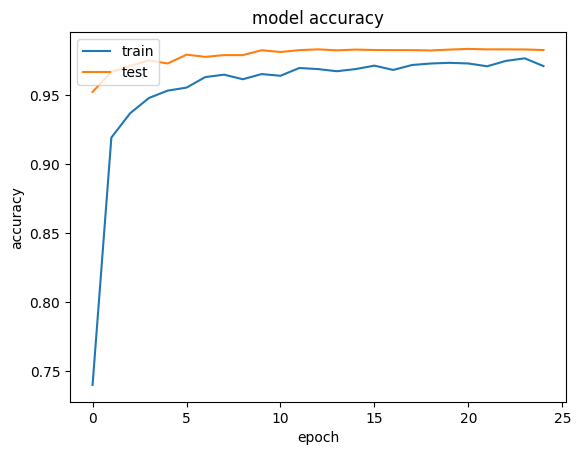

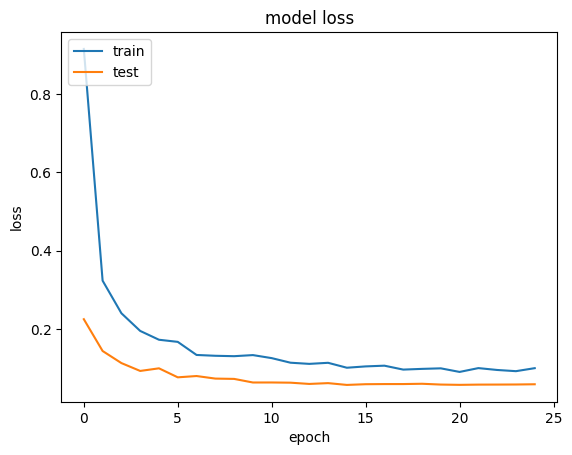

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AlexNet


In [14]:
input_shape = (32, 32, 3) #Cifar10 image size
image_size = 227 #size after resizing image
num_classes = 10

model2 = keras.models.Sequential([
    keras.layers.Resizing(image_size, image_size, interpolation="bilinear",input_shape=input_shape),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [15]:
model2.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model2.summary()
gc.collect()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 227, 227, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_2 (Batc  (None, 55, 55, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_3 (Batc  (None, 27, 27, 256)      1

8443

In [16]:
checkpoint_alex = ModelCheckpoint('/content/drive/MyDrive/Research/weights/alexnet.h5', 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
)  
plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)

In [ ]:
print("\n")
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
history = model2.fit(X_train,y_train,
          batch_size=32,
          epochs=30,
          validation_data=(X_valid, y_valid),
          callbacks = [plateau,checkpoint_alex]
         )
gc.collect()



Epoch 1/30
1172/1172 [==============================] - ETA: 0s - loss: 1.8543 - accuracy: 0.3881
Epoch 1: val_loss improved from inf to 1.57219, saving model to /content/drive/MyDrive/Research/weights/alexnet.h5
1172/1172 [==============================] - 72s 58ms/step - loss: 1.8543 - accuracy: 0.3881 - val_loss: 1.5722 - val_accuracy: 0.4271 - lr: 0.0100
Epoch 2/30
1172/1172 [==============================] - ETA: 0s - loss: 1.2967 - accuracy: 0.5366
Epoch 2: val_loss improved from 1.57219 to 1.26431, saving model to /content/drive/MyDrive/Research/weights/alexnet.h5
1172/1172 [==============================] - 61s 52ms/step - loss: 1.2967 - accuracy: 0.5366 - val_loss: 1.2643 - val_accuracy: 0.5472 - lr: 0.0100
Epoch 3/30
1171/1172 [============================>.] - ETA: 0s - loss: 1.0966 - accuracy: 0.6102
Epoch 3: val_loss improved from 1.26431 to 1.06044, saving model to /content/drive/MyDrive/Research/weights/alexnet.h5
1172/1172 [==============================] - 61s 52ms/s

In [ ]:
results = model.evaluate(test_data,test_label, batch_size=32, verbose=1)
print("test loss, test acc:", results)

In [ ]:
results = model2.evaluate(test_data,test_label, batch_size=32, verbose=1)
print("test loss, test acc:", results)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()